  <tr>
        <td>
            <div align="left">
                <font size=25px>
                    <b>X-Ray Pneumonia Prediction
                    </b>
                </font>
            </div>
        </td>
    </tr>

## Problem Statement
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children's Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patient's routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert. 

In this case, several deep learning models can be applied on these X-Ray images to extract unique features and classify **Normal** and **Pneumonia** patients. The normal chest X-ray depicts clear lungs without any areas of abnormal opacification in the image. Pneumonia typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), or manifests with a more diffuse "interstitial" pattern in both lungs.

## Data
The dataset is organized into 2 folders (train, test) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

## Content

1. **[Import Libraries & Load Images](#import_packages)**
    - 1.1 - [Normalizing Data](#normalize_data)
    - 1.2 - [Generating Images](#generate_images)
2. **[Understanding & Preparing Data](#data_preprocess)**
    - 2.1 - [EDA](#eda)
        - 2.1.1 - [Distribution of Training & Testing Images](#distribution)
        - 2.1.2 - [Visualizing Sample Images](#visualize_images)
    - 2.2 - [Handling Imbalanced Data](#handle_imbalance)
    - 2.3 - [Assign input shape](#assign_shape)
3. **[Model Building](#model_building)**
    - 3.1 - [Basic Convolutional Neural Network (CNN)](#model_cnn)
    - 3.2 - [VGG16](#model_vgg16)
    - 3.3 - [ResNet50](#model_resnet)
    - 3.4 - [InceptionV3](#model_inception)
4. **[Making Predictions](#make_predictions)**
    - 4.1 - [Basic Convolutional Neural Network (CNN)](#prediction_cnn)
    - 4.2 - [VGG16](#prediction_vgg16)
    - 4.3 - [ResNet50](#prediction_resnet)
    - 4.4 - [InceptionV3](#prediction_inception)
5. **[Conclusion](#conclusion)**

## Get Datasets

In [2]:
!unzip 'train.zip'
!unzip 'test.zip'

Archive:  train.zip
   creating: train/
   creating: train/NORMAL/
  inflating: train/NORMAL/IM-0115-0001.jpeg  
  inflating: train/NORMAL/IM-0117-0001.jpeg  
  inflating: train/NORMAL/IM-0119-0001.jpeg  
  inflating: train/NORMAL/IM-0122-0001.jpeg  
  inflating: train/NORMAL/IM-0125-0001.jpeg  
  inflating: train/NORMAL/IM-0127-0001.jpeg  
  inflating: train/NORMAL/IM-0128-0001.jpeg  
  inflating: train/NORMAL/IM-0129-0001.jpeg  
  inflating: train/NORMAL/IM-0131-0001.jpeg  
  inflating: train/NORMAL/IM-0133-0001.jpeg  
  inflating: train/NORMAL/IM-0135-0001.jpeg  
  inflating: train/NORMAL/IM-0137-0001.jpeg  
  inflating: train/NORMAL/IM-0140-0001.jpeg  
  inflating: train/NORMAL/IM-0141-0001.jpeg  
  inflating: train/NORMAL/IM-0143-0001.jpeg  
  inflating: train/NORMAL/IM-0145-0001.jpeg  
  inflating: train/NORMAL/IM-0147-0001.jpeg  
  inflating: train/NORMAL/IM-0149-0001.jpeg  
  inflating: train/NORMAL/IM-0151-0001.jpeg  
  inflating: train/NORMAL/IM-0152-0001.jpeg  
  inflating: 

<a id='import_packages'></a>
## 1. Import Libraries & Load Images

In [1]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,  Activation, GlobalMaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras import metrics
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pandas as pd
import math
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Check Devices

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14872999293382522936,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3343662705880199320
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11940620147267468203
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14644711296
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4462591175063678029
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"]

In [3]:
training_path = "train"
test_path = "test"

<a id='normalize_data'></a>
### 1.1. Normalizing Data & Image Augmentation

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2,
                                      fill_mode='nearest')  #Divide pixels by 255(where pixel value range from 0-255) and scale them between 0-1
test_datagen = ImageDataGenerator(rescale=1./255)

<a id='generate_images'></a>
### 1.2. Generating Images

In [5]:
train_generator = train_datagen.flow_from_directory(training_path, target_size=(150,150), class_mode='binary', classes=['NORMAL', 'PNEUMONIA'])
test_generator = test_datagen.flow_from_directory(test_path, target_size=(150,150), class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
train_class = train_generator.classes
test_class = test_generator.classes

<a id='data_preprocess'></a>
## 2. Understanding & Preparing Data

<a id='eda'></a>
### 2.1. EDA

<a id='distribution'></a>
### 2.1.1. Distribution of Training & Testing Datasets

In [7]:
from collections import Counter

train_counter = Counter(train_class)
test_counter = Counter(test_class)
print("Training: {}".format(train_counter))
print("Testing: {}".format(test_counter))

Training: Counter({1: 3875, 0: 1341})
Testing: Counter({1: 390, 0: 234})


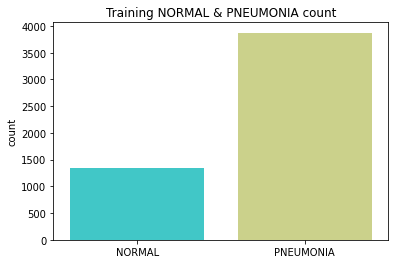

In [8]:
sns.countplot(x=train_class, palette="rainbow")
plt.title("Training NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

From the above plot, it appears that there are more number of data(images) for Pneumonia patients than Normal patients for training the model. Hence, we will apply a technique to handle Imbalanced Data in order to avoid biasnes for one class (2.2 - [Handling Imbalanced Data](#handle_imbalance)).

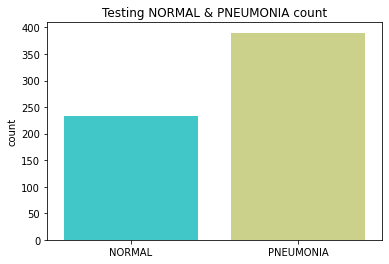

In [9]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Testing NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

<a id='visualize_images'></a>
### 2.1.2. Visualizing Sample Images

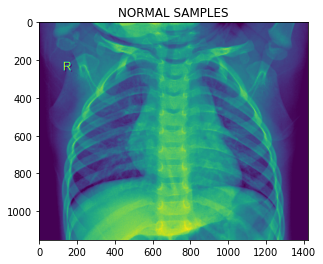

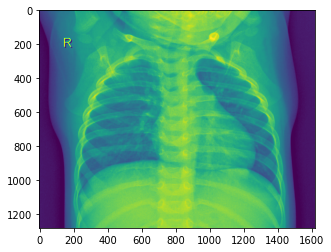

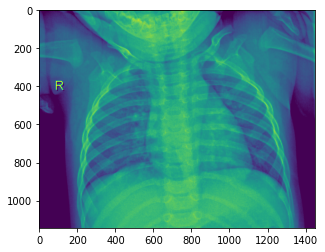

In [10]:
sample_li = [training_path + '/NORMAL/IM-0117-0001.jpeg', training_path + '/NORMAL/IM-0122-0001.jpeg', training_path + '/NORMAL/IM-0131-0001.jpeg']
plt.title("NORMAL SAMPLES")
for i in sample_li:
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.show()

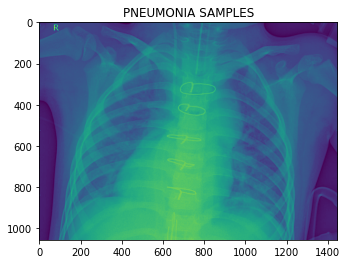

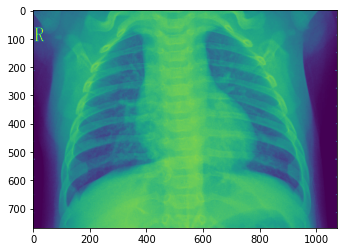

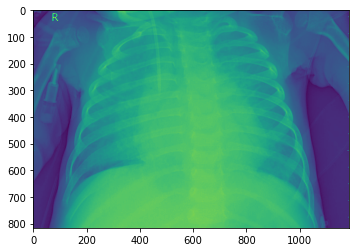

In [11]:
sample_li = [training_path + '/PNEUMONIA/person2_bacteria_3.jpeg', training_path + '/PNEUMONIA/person1000_virus_1681.jpeg', training_path + '/PNEUMONIA/person1004_bacteria_2935.jpeg']
plt.title("PNEUMONIA SAMPLES")
for i in sample_li:
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.show()

<a id='handle_imbalance'></a>
### 2.2. Handling Imbalanced Data
We are generating weights to handle imbalanced unequal data

In [12]:
df = pd.DataFrame({'data':train_generator.classes})
no_pne = int(df[df.data == train_generator.class_indices['NORMAL']].count())
yes_pne = int(df[df.data == train_generator.class_indices['PNEUMONIA']].count())

imb_rat = round(yes_pne / no_pne, 2)

no_weight = imb_rat
yes_weight = 1.0

cweights = {
    train_generator.class_indices['NORMAL']:no_weight,
    train_generator.class_indices['PNEUMONIA']:yes_weight
}

text = "Normal:{:.0f}\nPneumonia:{:.0f}\nImbalance Ratio: {:.2f}\n".format(no_pne, yes_pne, imb_rat)
print(text)
text = "Using class_weights as:\nNormal:{:.2f}\nPneumonia:{:.2f}\n".format(no_weight, yes_weight)
print(text)

Normal:1341
Pneumonia:3875
Imbalance Ratio: 2.89

Using class_weights as:
Normal:2.89
Pneumonia:1.00



<a id='assign_shape'></a>
### 2.3. Assign input shape
We are assigning input shape based on color channels

In [13]:
img_width, img_height = 150, 150

In [14]:
if k.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

<a id='model_building'></a>
## 3. Model Building

#### Custom F1 Score function

In [15]:
def f1_score(y_true, y_pred):
    true_positives = k.sum(k.round(k.clip(y_true * y_pred, 0, 1)))
    
    #Precision
    predicted_positives = k.sum(k.round(k.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + k.epsilon())
    
    #Recall
    possible_positives = k.sum(k.round(k.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + k.epsilon())
    
    return 2 * ((precision * recall) / (precision + recall + k.epsilon()))

<a id='model_cnn'></a>
### 3.1. Basic Convolutional Network (CNN)

In [16]:
model = Sequential()
#Feature Extraction
#Block 1
model.add(Conv2D(32,(3,3),input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Classification
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 2 because we have normal and pneumonia classes

model.summary()

[2022-03-29 11:15:43.772 tensorflow-2-3-gpu--ml-g4dn-xlarge-afdc4952d33ce09f2a7db7721a57:7721 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-29 11:15:43.798 tensorflow-2-3-gpu--ml-g4dn-xlarge-afdc4952d33ce09f2a7db7721a57:7721 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
___________________

In [17]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), f1_score])
hist = model.fit(train_generator, epochs=25, batch_size=64, class_weight=cweights, validation_data=test_generator, verbose=1)

Epoch 1/25
163/163 [==============================] - 80s 488ms/step - loss: 0.4840 - accuracy: 0.8495 - precision: 0.9766 - recall: 0.8170 - f1_score: 0.8884 - val_loss: 8.4091 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - val_f1_score: 0.7671
Epoch 2/25
163/163 [==============================] - 76s 466ms/step - loss: 0.3587 - accuracy: 0.8986 - precision: 0.9750 - recall: 0.8862 - f1_score: 0.9287 - val_loss: 15.9167 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - val_f1_score: 0.7618
Epoch 3/25
163/163 [==============================] - 76s 465ms/step - loss: 0.3226 - accuracy: 0.9120 - precision: 0.9784 - recall: 0.9014 - f1_score: 0.9385 - val_loss: 6.6302 - val_accuracy: 0.6234 - val_precision: 0.6244 - val_recall: 0.9974 - val_f1_score: 0.7678
Epoch 4/25
163/163 [==============================] - 76s 464ms/step - loss: 0.3014 - accuracy: 0.9201 - precision: 0.9811 - recall: 0.9099 - f1_score: 0.9444 - val_loss: 5.5722 - val_accuracy

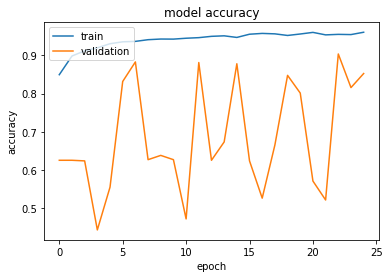

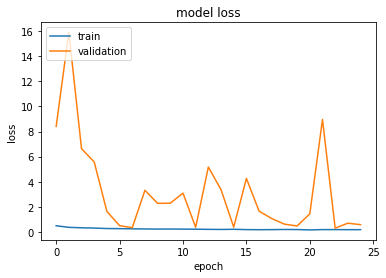

In [18]:
# "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<a id='model_vgg16'></a>
### 3.2. VGG16

VGG16 is a pre-trained deep learning vision model architecture with 16 layers and 5 blocks of Conv2D & MaxPool2D layers along with Flatten & Dense layers. 

In [19]:
num_of_classes = 2
batch_size = 32

base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
    
for layer in base_model.layers:
    if layer.name != 'block5_conv3':
        layer.trainable = False
    else:
        layer.trainable = True

x = base_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(x) #Pooling + Flatten
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=x)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [20]:
optSGD = optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model1.compile(loss='binary_crossentropy', optimizer=optSGD, metrics=['accuracy', metrics.Precision(), metrics.Recall(), f1_score])

In [21]:
hist_vgg = model1.fit(train_generator,
                    validation_data=test_generator,
                    class_weight=cweights,
                    epochs=70, verbose=1)

Epoch 1/70
163/163 [==============================] - 77s 475ms/step - loss: 0.8352 - accuracy: 0.7055 - precision_1: 0.8808 - recall_1: 0.6981 - f1_score: 0.7701 - val_loss: 0.4639 - val_accuracy: 0.8446 - val_precision_1: 0.9536 - val_recall_1: 0.7897 - val_f1_score: 0.8617
Epoch 2/70
163/163 [==============================] - 76s 464ms/step - loss: 0.5407 - accuracy: 0.8616 - precision_1: 0.9552 - recall_1: 0.8537 - f1_score: 0.8992 - val_loss: 0.3966 - val_accuracy: 0.8365 - val_precision_1: 0.9586 - val_recall_1: 0.7718 - val_f1_score: 0.8569
Epoch 3/70
163/163 [==============================] - 76s 463ms/step - loss: 0.4270 - accuracy: 0.8859 - precision_1: 0.9680 - recall_1: 0.8754 - f1_score: 0.9181 - val_loss: 0.3079 - val_accuracy: 0.8846 - val_precision_1: 0.9015 - val_recall_1: 0.9154 - val_f1_score: 0.9057
Epoch 4/70
163/163 [==============================] - 76s 465ms/step - loss: 0.3571 - accuracy: 0.9112 - precision_1: 0.9763 - recall_1: 0.9025 - f1_score: 0.9370 - val_

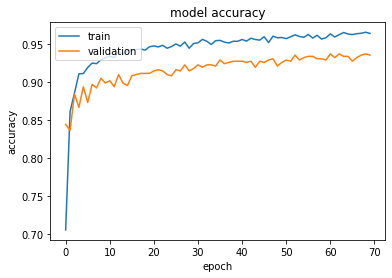

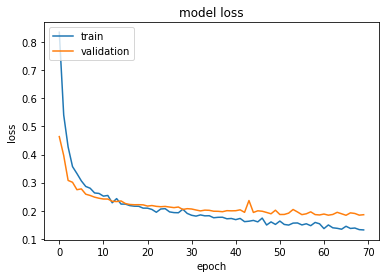

In [22]:
# "Accuracy"
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<a id='model_resnet'></a>
### 3.3. ResNet50

ResNet or Residual Network is a pre-trained deep learning model architecture which was built to solve the problem of the vanishing/exploding gradient. ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. 

In [23]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in resnet_model.layers:
    layer.trainable = False
    
x = Flatten()(resnet_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=resnet_model.input, outputs=x)
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [24]:
model2.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adamax(learning_rate=0.001),
                  metrics=['accuracy', metrics.Precision(), metrics.Recall(), f1_score])

hist_rest = model2.fit(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=70,
)

Epoch 1/70
163/163 [==============================] - 36s 224ms/step - loss: 0.9267 - accuracy: 0.6302 - precision_2: 0.8319 - recall_2: 0.6294 - f1_score: 0.6388 - val_loss: 0.4748 - val_accuracy: 0.7885 - val_precision_2: 0.7854 - val_recall_2: 0.9103 - val_f1_score: 0.8412
Epoch 2/70
163/163 [==============================] - 36s 219ms/step - loss: 0.6725 - accuracy: 0.7880 - precision_2: 0.9212 - recall_2: 0.7814 - f1_score: 0.8359 - val_loss: 0.3920 - val_accuracy: 0.8205 - val_precision_2: 0.8174 - val_recall_2: 0.9179 - val_f1_score: 0.8620
Epoch 3/70
163/163 [==============================] - 35s 216ms/step - loss: 0.5395 - accuracy: 0.8357 - precision_2: 0.9457 - recall_2: 0.8263 - f1_score: 0.8780 - val_loss: 0.7655 - val_accuracy: 0.6074 - val_precision_2: 0.9801 - val_recall_2: 0.3795 - val_f1_score: 0.5304
Epoch 4/70
163/163 [==============================] - 36s 221ms/step - loss: 0.4903 - accuracy: 0.8499 - precision_2: 0.9492 - recall_2: 0.8431 - f1_score: 0.8896 - val_

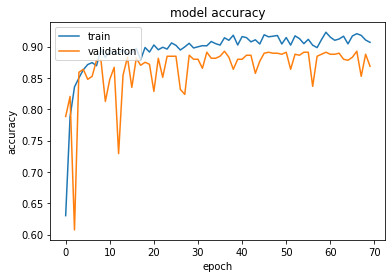

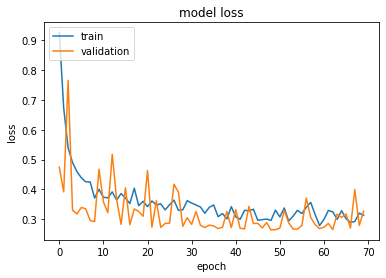

In [25]:
# "Accuracy"
plt.plot(hist_rest.history['accuracy'])
plt.plot(hist_rest.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_rest.history['loss'])
plt.plot(hist_rest.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<a id='model_inception'></a>
### 3.4. InceptionV3

Inception v3 is a deep learning model architecture assisting in image analysis and object detection consisting 42 layers of Conv2D, BatchNormalization, MaxPooling, AveragePooling, Mixed layers.

In [26]:
base_model = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=output)
model3.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

In [27]:
opt = optimizers.Adam(learning_rate=0.0003)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', metrics.Precision(), metrics.Recall(), f1_score])

hist_incep = model3.fit(
    train_generator, 
    validation_data = test_generator,
    class_weight=cweights,
    workers=10,
    epochs=70,
)

Epoch 1/70
163/163 [==============================] - 36s 223ms/step - loss: 0.4347 - accuracy: 0.8547 - precision_3: 0.9744 - recall_3: 0.8261 - f1_score: 0.8934 - val_loss: 0.4649 - val_accuracy: 0.8237 - val_precision_3: 0.9430 - val_recall_3: 0.7641 - val_f1_score: 0.8384
Epoch 2/70
163/163 [==============================] - 35s 218ms/step - loss: 0.3063 - accuracy: 0.9132 - precision_3: 0.9782 - recall_3: 0.9032 - f1_score: 0.9392 - val_loss: 0.2742 - val_accuracy: 0.8926 - val_precision_3: 0.8873 - val_recall_3: 0.9487 - val_f1_score: 0.9158
Epoch 3/70
163/163 [==============================] - 35s 217ms/step - loss: 0.2902 - accuracy: 0.9247 - precision_3: 0.9754 - recall_3: 0.9218 - f1_score: 0.9476 - val_loss: 0.2827 - val_accuracy: 0.8942 - val_precision_3: 0.9241 - val_recall_3: 0.9051 - val_f1_score: 0.9101
Epoch 4/70
163/163 [==============================] - 35s 214ms/step - loss: 0.2661 - accuracy: 0.9298 - precision_3: 0.9790 - recall_3: 0.9254 - f1_score: 0.9515 - val_

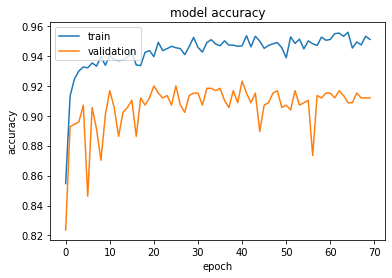

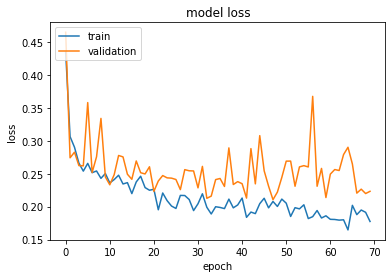

In [28]:
# "Accuracy"
plt.plot(hist_incep.history['accuracy'])
plt.plot(hist_incep.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist_incep.history['loss'])
plt.plot(hist_incep.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<a id='make_predictions'></a>
## 4. Making Predictions

<a id='prediction_cnn'></a>
### 4.1. Basic Convolutional Neural Network (CNN)

In [29]:
predict_cnn = model.predict(test_generator).flatten()
predict_cnn[predict_cnn > 0.5] = 1
predict_cnn[predict_cnn <= 0.5] = 0
print("Predicted Count: {}".format(Counter(predict_cnn)))
print("Test Count: {}".format(Counter(test_class)))

Predicted Count: Counter({1.0: 406, 0.0: 218})
Test Count: Counter({1: 390, 0: 234})


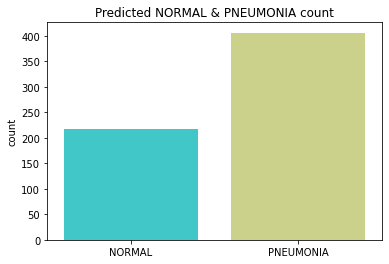

In [30]:
sns.countplot(x=predict_cnn, palette="rainbow")
plt.title("Predicted NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

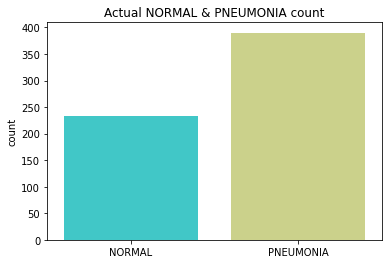

In [31]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Actual NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

From the above count we can see that around 96.05% of **Pneumonia** patients were predicted correctly and 93.59% of **Normal** patients were predicted correctly.

In [69]:
result_tabulation = pd.DataFrame(columns=["Model", "Loss", "Accuracy", "Precision", "Recall", "F1-Score"])

pred_cnn = model.evaluate(test_generator)
CNN = pd.Series({"Model": "Basic CNN", "Loss": pred_cnn[0], "Accuracy": pred_cnn[1], "Precision": pred_cnn[2], "Recall": pred_cnn[3], "F1-Score": pred_cnn[4]})
result_tabulation = result_tabulation.append(CNN, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 255ms/step - loss: 0.5721 - accuracy: 0.8526 - precision: 0.8670 - recall: 0.9026 - f1_score: 0.8792


,Model,Loss,Accuracy,Precision,Recall,F1-Score
0,Basic CNN,0.572124,0.852564,0.866995,0.902564,0.879184


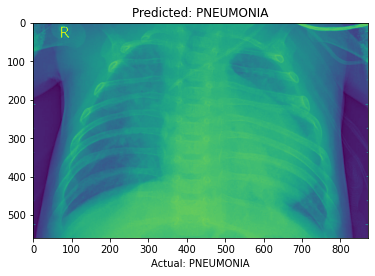

In [33]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred=image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred, axis=0)

result = model.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

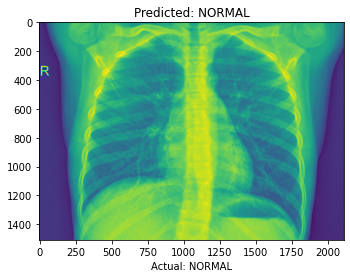

In [34]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

<a id='prediction_vgg16'></a>
### 4.2. VGG16

In [35]:
predict_vgg = model1.predict(test_generator).flatten()
predict_vgg[predict_vgg > 0.5] = 1
predict_vgg[predict_vgg <= 0.5] = 0
print("Predicted Count: {}".format(Counter(predict_vgg)))
print("Test Count: {}".format(Counter(test_class)))

Predicted Count: Counter({1.0: 402, 0.0: 222})
Test Count: Counter({1: 390, 0: 234})


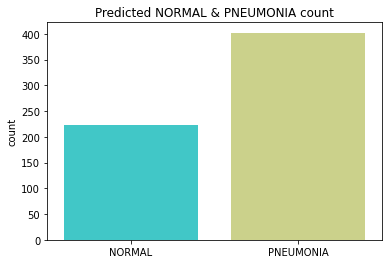

In [36]:
sns.countplot(x=predict_vgg, palette="rainbow")
plt.title("Predicted NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

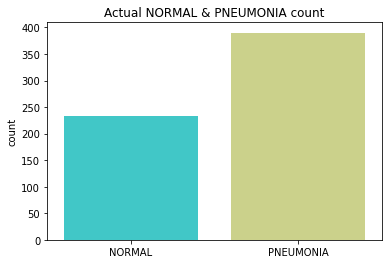

In [79]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Actual NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

From the above count we can see that around 97% of **Pneumonia** patients were predicted correctly and 94.87% of **Normal** patients were predicted correctly.

In [70]:
pred_vgg = model1.evaluate(test_generator)
VGG =  pd.Series({"Model": "VGG16", "Loss": pred_vgg[0], "Accuracy": pred_vgg[1], "Precision": pred_vgg[2], "Recall": pred_vgg[3], "F1-Score": pred_vgg[4]})
result_tabulation = result_tabulation.append(VGG, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 232ms/step - loss: 0.1860 - accuracy: 0.9359 - precision_1: 0.9353 - recall_1: 0.9641 - f1_score: 0.9485


,Model,Loss,Accuracy,Precision,Recall,F1-Score
0,Basic CNN,0.572124,0.852564,0.866995,0.902564,0.879184
1,VGG16,0.185981,0.935897,0.935323,0.964103,0.948521


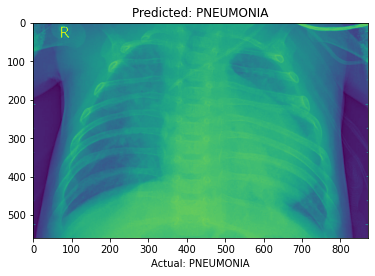

In [39]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model1.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

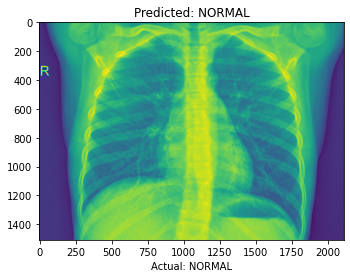

In [40]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model1.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

<a id='prediction_resnet'></a>
### 4.3. ResNet50

In [71]:
predict_res = model2.predict(test_generator).flatten()
predict_res[predict_res > 0.5] = 1
predict_res[predict_res <= 0.5] = 0
print("Predicted Count: {}".format(Counter(predict_res)))
print("Test Count: {}".format(Counter(test_class)))

Predicted Count: Counter({1.0: 452, 0.0: 172})
Test Count: Counter({1: 390, 0: 234})


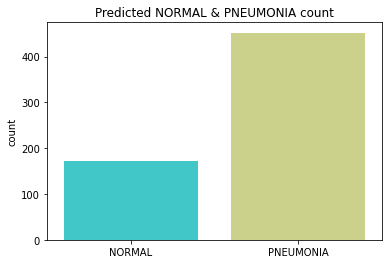

In [72]:
sns.countplot(x=predict_res, palette="rainbow")
plt.title("Predicted NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

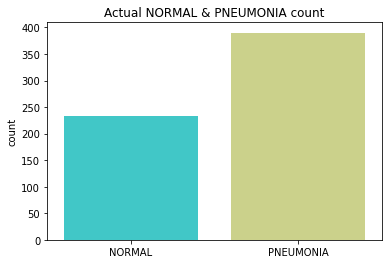

In [43]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Actual NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

From the above count we can see that around 86.28% of **Pneumonia** patients were predicted correctly and 73.04% of **Normal** patients were predicted correctly.

In [73]:
pred_res = model2.evaluate(test_generator)
RESNET =  pd.Series({"Model": "ResNet50", "Loss": pred_res[0], "Accuracy": pred_res[1], "Precision": pred_res[2], "Recall": pred_res[3], "F1-Score": pred_res[4]})
result_tabulation = result_tabulation.append(RESNET, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 238ms/step - loss: 0.3271 - accuracy: 0.8686 - precision_2: 0.8407 - recall_2: 0.9744 - f1_score: 0.9003


,Model,Loss,Accuracy,Precision,Recall,F1-Score
0,Basic CNN,0.572124,0.852564,0.866995,0.902564,0.879184
1,VGG16,0.185981,0.935897,0.935323,0.964103,0.948521
2,ResNet50,0.327104,0.868590,0.840708,0.974359,0.900346


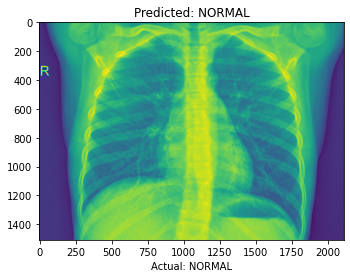

In [45]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model2.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

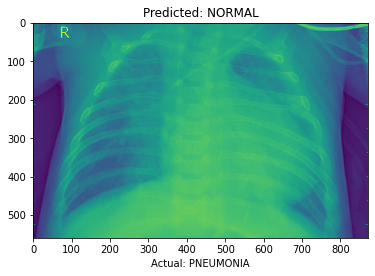

In [46]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model2.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

<a id='prediction_inception'></a>
### 4.4. InceptionV3

In [47]:
predict_incep = model3.predict(test_generator).flatten()
predict_incep[predict_incep > 0.5] = 1
predict_incep[predict_incep <= 0.5] = 0
print("Predicted Count: {}".format(Counter(predict_incep)))
print("Test Count: {}".format(Counter(test_class)))

Predicted Count: Counter({1.0: 403, 0.0: 221})
Test Count: Counter({1: 390, 0: 234})


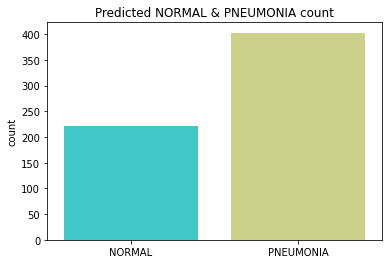

In [48]:
sns.countplot(x=predict_incep, palette="rainbow")
plt.title("Predicted NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

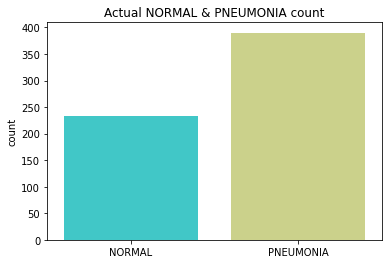

In [49]:
sns.countplot(x=test_class, palette="rainbow")
plt.title("Actual NORMAL & PNEUMONIA count")
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.show()

From the above count we can see that around 96.77% of **Pneumonia** patients were predicted correctly and 94.44% of **Normal** patients were predicted correctly.

In [74]:
pred_incep = model3.evaluate(test_generator)
INCEP =  pd.Series({"Model": "InceptionV3", "Loss": pred_incep[0], "Accuracy": pred_incep[1], "Precision": pred_incep[2], "Recall": pred_incep[3], "F1-Score": pred_incep[4]})
result_tabulation = result_tabulation.append(INCEP, ignore_index=True)
result_tabulation

20/20 [==============================] - 5s 237ms/step - loss: 0.2233 - accuracy: 0.9119 - precision_3: 0.9156 - recall_3: 0.9462 - f1_score: 0.9310


,Model,Loss,Accuracy,Precision,Recall,F1-Score
0,Basic CNN,0.572124,0.852564,0.866995,0.902564,0.879184
1,VGG16,0.185981,0.935897,0.935323,0.964103,0.948521
2,ResNet50,0.327104,0.868590,0.840708,0.974359,0.900346
3,InceptionV3,0.223283,0.911859,0.915633,0.946154,0.930973


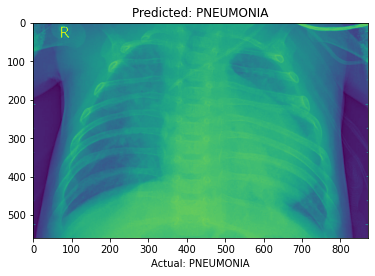

In [51]:
img_pred = image.load_img("test/PNEUMONIA/person1_virus_11.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model3.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: PNEUMONIA")

img = mpimg.imread('test/PNEUMONIA/person1_virus_11.jpeg')
imgplot = plt.imshow(img)
plt.show()

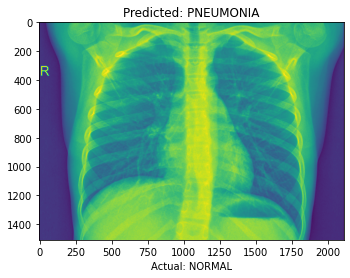

In [52]:
img_pred = image.load_img("test/NORMAL/IM-0003-0001.jpeg", target_size=(150, 150))

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

result = model3.predict(img_pred)

if result[0][0] == 1:
    prediction = "Predicted: PNEUMONIA"
else:
    prediction = "Predicted: NORMAL"
plt.title(prediction)
plt.xlabel("Actual: NORMAL")

img = mpimg.imread('test/NORMAL/IM-0003-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

<a id='conclusion'></a>
## 5. Conclusion

Loss: Loss function tells how good our model is in predictions & it is minimum if predictions are closer to the actual values, Binary cross entropy used compares each of the predicted probabilities to actual class output which can be either 0 or 1, calculates the score that penalizes the probabilities based on the distance from the expected value, Accuracy – Percent of correct predictions, Recall – Percent of positive (Pneumonia) predictions we were able to catch, Precision – Percent of correct positive predictions, F1-Score – Test accuracy.

In [75]:
results = result_tabulation.set_index("Model")
results

,Loss,Accuracy,Precision,Recall,F1-Score
Model,,,,,
Basic CNN,0.572124,0.852564,0.866995,0.902564,0.879184
VGG16,0.185981,0.935897,0.935323,0.964103,0.948521
ResNet50,0.327104,0.868590,0.840708,0.974359,0.900346
InceptionV3,0.223283,0.911859,0.915633,0.946154,0.930973


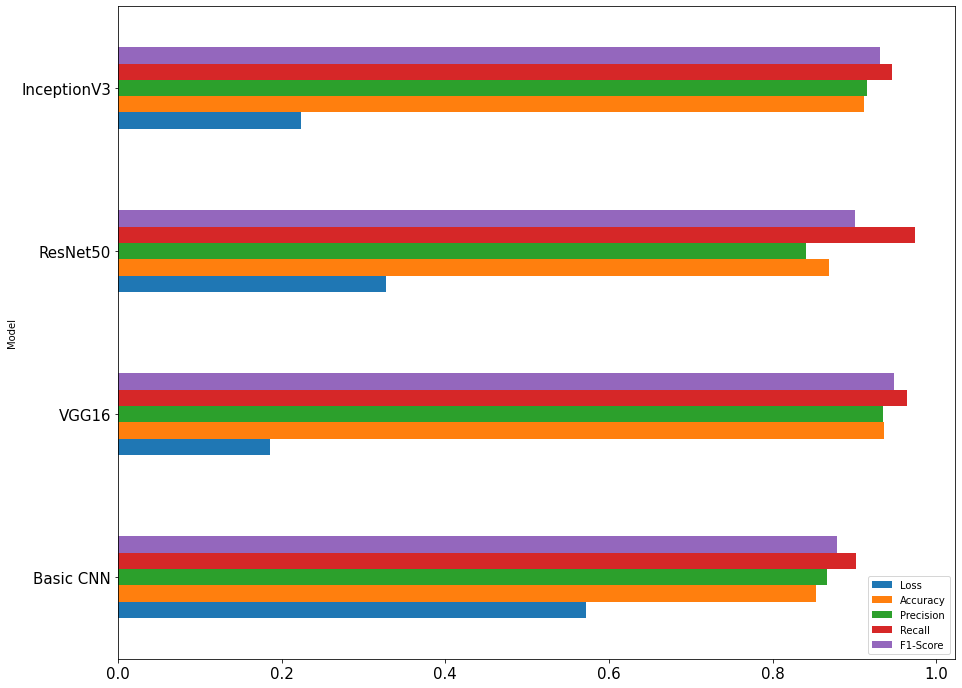

In [80]:
results.plot.barh(figsize=(15, 12), fontsize=15)
plt.legend(loc='best')
plt.show()

#### From the above results, we can conclude that VGG16 is the most stable and better performing model as compared to Basic Convolutional Neural Network (CNN), RestNet50, InceptionV3 models. Hence, VGG16 is the preferred model for the prediction of Pneumonia patients.